<a href="https://www.kaggle.com/code/bhavinmoriya/monte-carlo-simulation-and-randomness?scriptVersionId=111100768" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

We use MCS to,
1. Rolling dice game
2. predict the Gross profit of the Company.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas_datareader as web
from datetime import datetime as dt, timedelta as td
import seaborn as sns
sns.set()
%matplotlib inline

# Rolling dice

We are going to role two dice.
- if sum is 7 John gets 5
- else Rob gets 1
Find out game is beneficial for whom?

In [2]:
def monte_carlo(n=1000):
    '''sum of two dice'''
    result = np.zeros(2)
    
    for i in range(n):
        dice_sum = np.sum(np.random.randint(1,7,2))
        if dice_sum == 7:
            result[0] += 1
        else:
            result[1] += 1
    return result


(array([  4.,  16.,  47., 134., 203., 277., 178.,  93.,  32.,  16.]),
 array([128. , 135.2, 142.4, 149.6, 156.8, 164. , 171.2, 178.4, 185.6,
        192.8, 200. ]),
 <BarContainer object of 10 artists>)

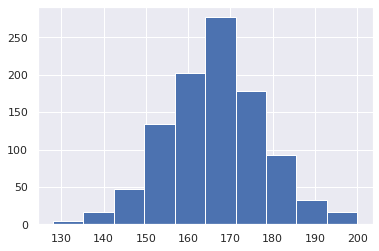

In [3]:
# On average how much John wins

iteration = 1000
john = np.zeros(iteration)
for i in range(iteration):
    john[i] = monte_carlo()[0]
plt.hist(john)

In [4]:
john.mean()

166.321

In [5]:
john_wins = 5 * john.mean() - (1000 - john.mean())
print(f'On an average John wins : {john_wins}')

On an average John wins : -2.0739999999999554


As we know expectation of John making money is $5 * (1/6) + (-1) * (5/6) = 0$, which is almost what we are getting above. One can run it for more iterations and see winning converging to zero. What if it was getting 12 and paying 2?

# Find Gross profit

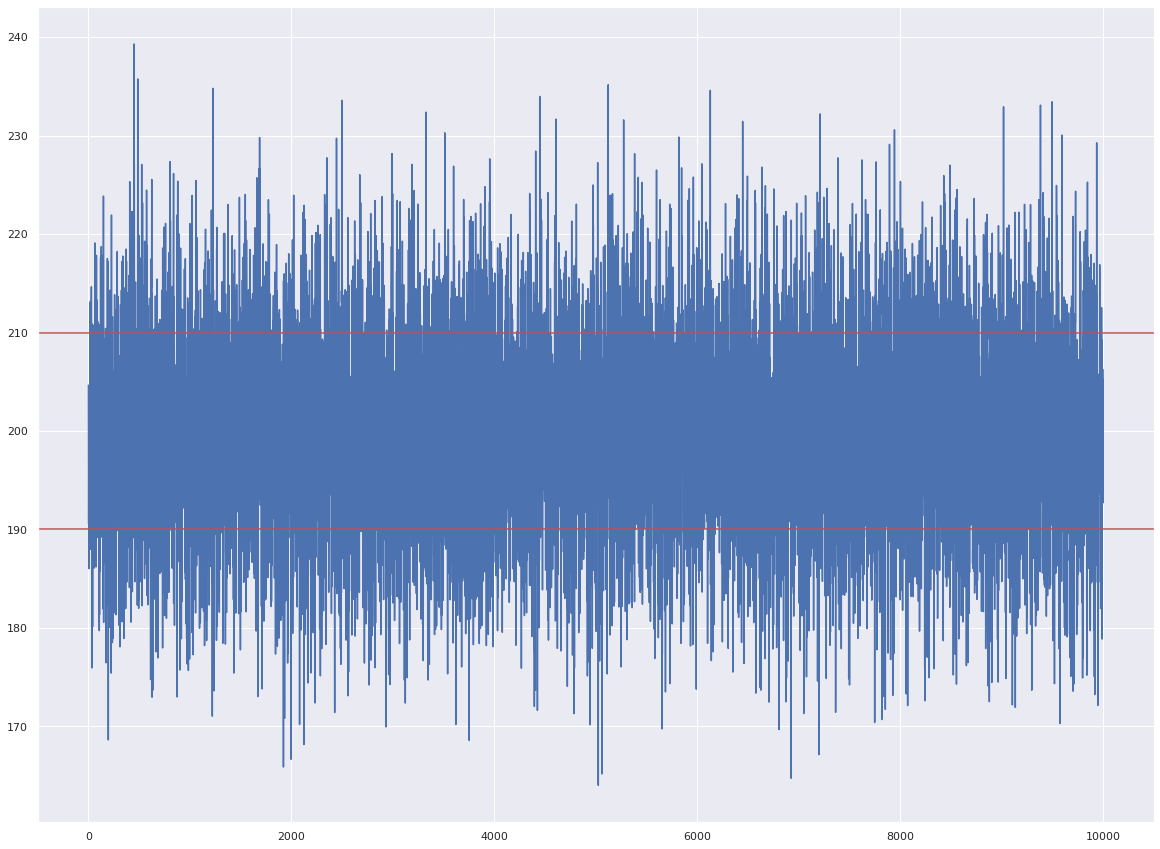

In [6]:
rev_mean = 200 # $200m revenue of company
rev_std = 10 # deviation of the rev
iteration = 10_000

# Generate revs with given mean and std dev
revs = np.random.normal(rev_mean, rev_std, size=iteration)
plt.figure(figsize=(20,15))
plt.plot(revs)
plt.axhline(rev_mean - rev_std, c='r')
plt.axhline(rev_mean + rev_std, c='r')

# COGS (Cost of goods sold)

In [7]:
cogs_percent = np.random.normal(.6,.1)
print(f'We are taking COGS to be about {cogs_percent} of a REV.')
cogs = - revs * cogs_percent

We are taking COGS to be about 0.5811213010792878 of a REV.


In [8]:
gross_profits = revs + cogs 
gpmin, gpmax, gpmean, gpstd = gross_profits.min(), gross_profits.max(), gross_profits.mean(), gross_profits.std()
print(f'Gross profit min, max, mean and std are : {gpmin, gpmax, gpmean, gpstd}')
# plt.bar(x='gpmin, gpmax, gpmean, gpstd'.split(','), y=[gpmin, gpmax, gpmean, gpstd], height=1)

Gross profit min, max, mean and std are : (68.70788777108625, 100.23811576629299, 83.6887276469254, 4.255652424073304)


We expect gross profit would be about 74m with and error of about 3.77m

# Predicting a Stock Price

$$ Price Today = Price Yesterday * \exp(Drift + Volatility) $$
where Drift = $\mu - .5 * \sigma^2$ and Volatility = $\sigma * Z(Rand(0,1)$.

In [9]:
def stock_price(stock = 'TSLA', period=1000, num_preds=10):
    '''Predicting the stock price for next day using MC and using past 10 years data'''
    df = web.get_data_yahoo(stock, start=dt.today() -  td(365*10))['Adj Close']
    log_ret = np.log(df.pct_change() + 1)
    mu = log_ret.mean()
    var = log_ret.var()
    drift = mu - (.5 * var)
    std = var ** .5
    Z = norm.ppf(np.random.rand(period, num_preds))
    volatility = std * Z
    daily_returns = np.exp(drift + volatility)
    stock_price = np.zeros_like(daily_returns)
    S0 = df.iloc[-1]
    # Last day value is taken as a predictor for next day.
    stock_price[0] = S0
    
    for i in range(1, period):
        # S_(t-1) would give S_t
        stock_price[i] = S0 * daily_returns[i]
        
    return df, var, drift, stock_price

In [10]:
df, var, drift, price = stock_price()

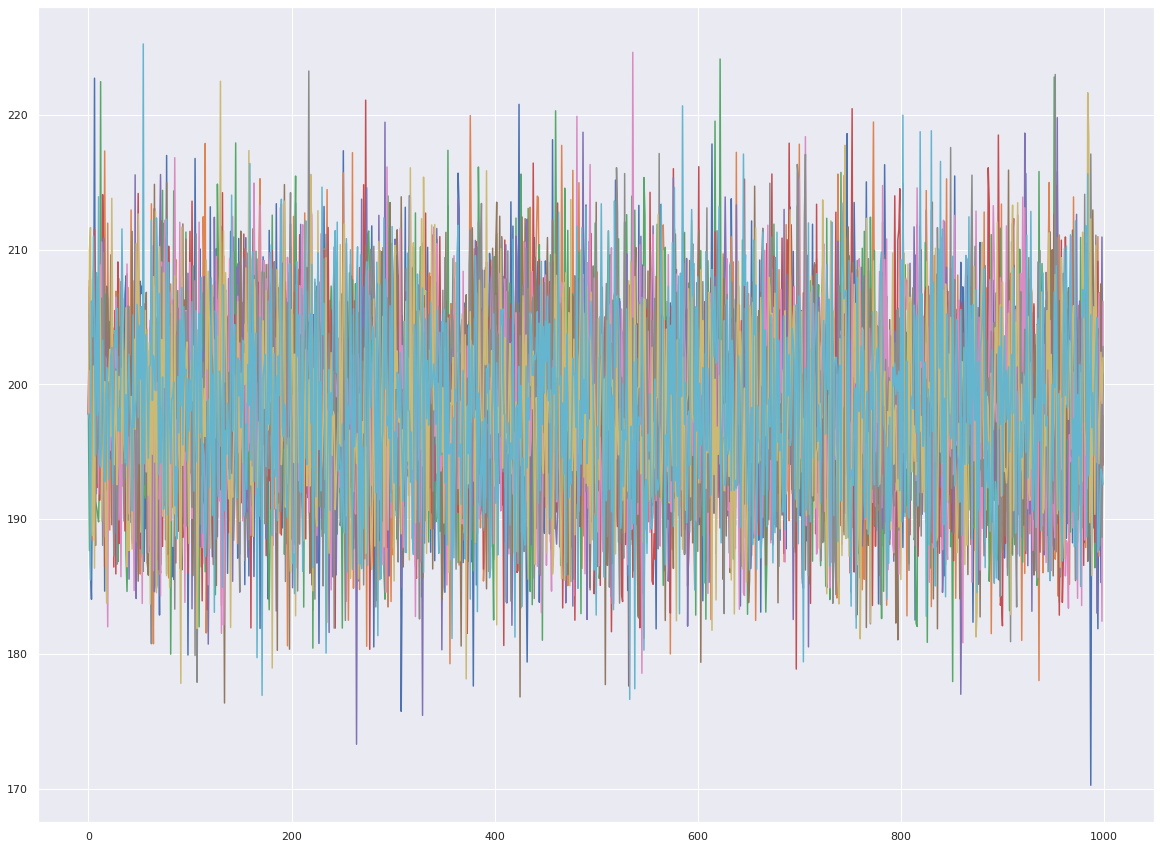

In [11]:
plt.figure(figsize=(20,15))
plt.plot(price);

That is extremely messy. SO we shall plot just three predictions below and we shall also try to predict just 50 future predictions to get the feel.

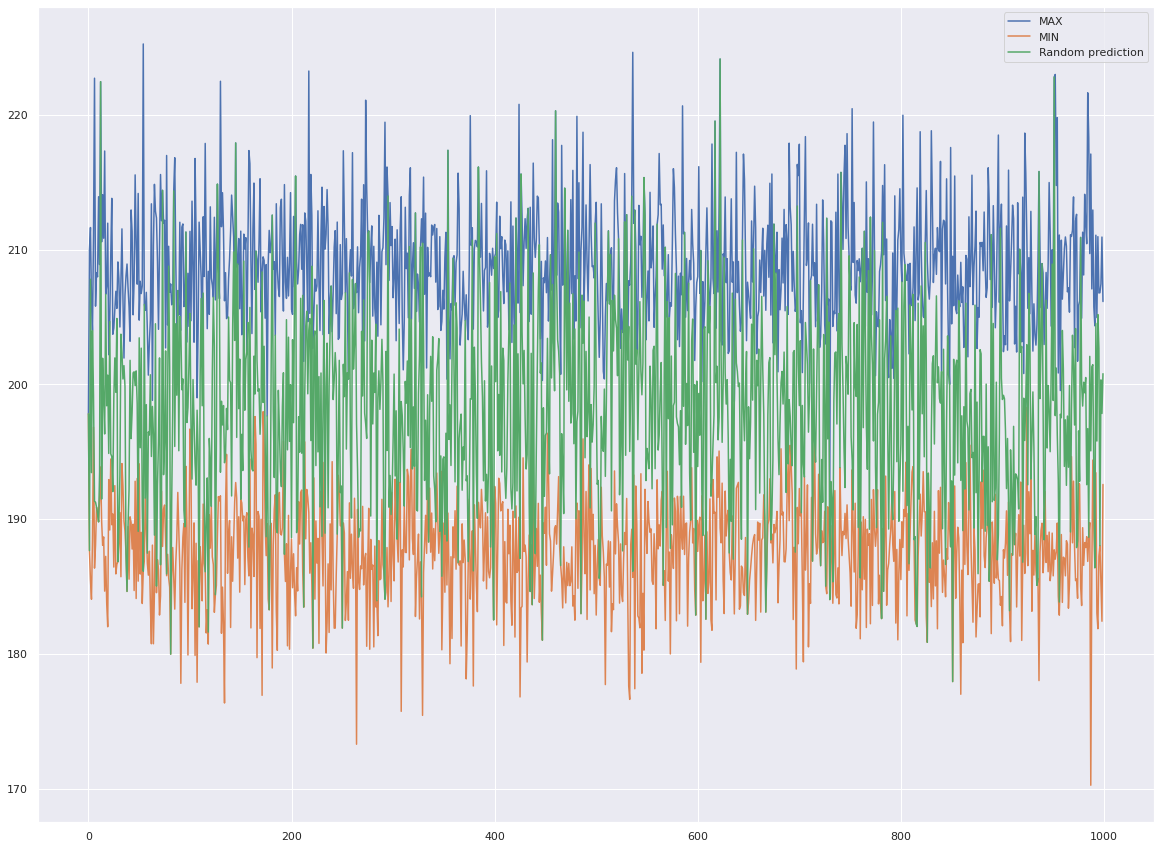

In [12]:
plt.figure(figsize=(20,15))
plt.plot(price.max(axis=1), label='MAX');
plt.plot(price.min(axis=1), label='MIN');
plt.plot(price[:,np.random.choice(range(10))], label='Random prediction');
plt.legend()

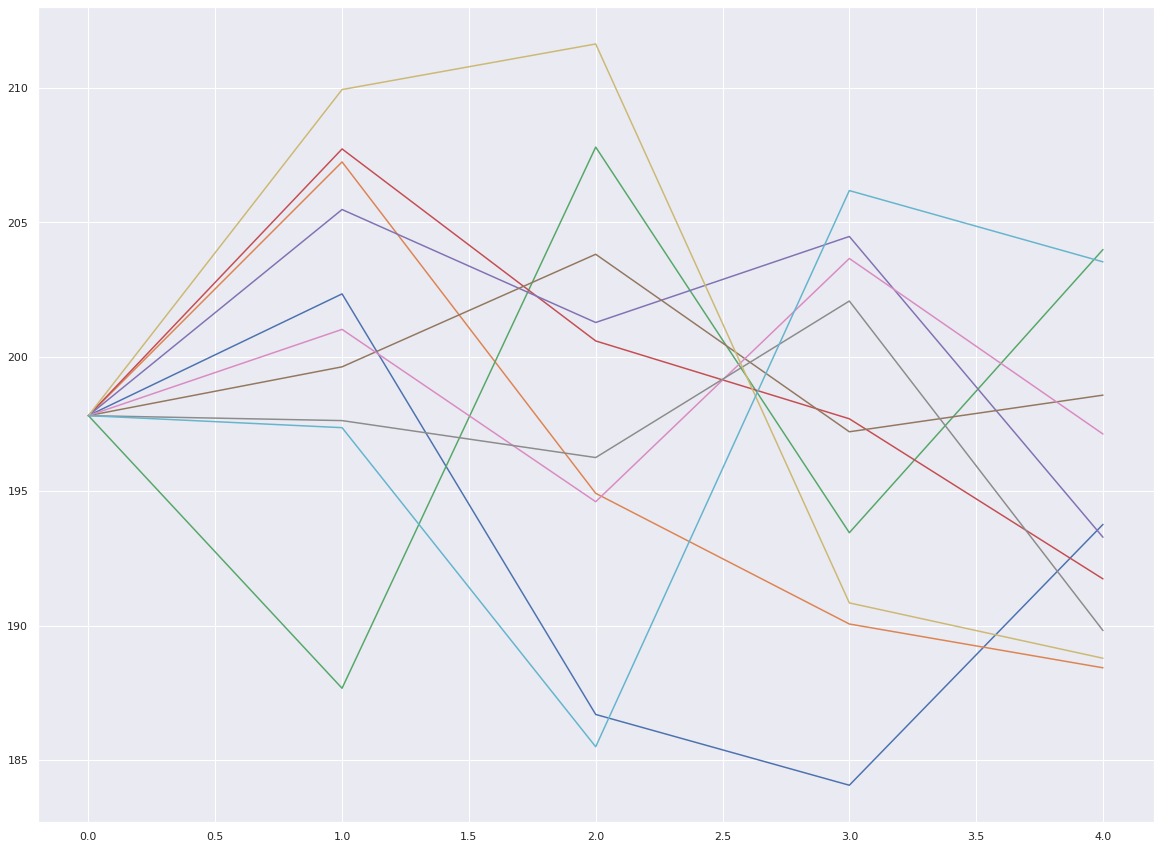

In [13]:
new = price[:5]
plt.figure(figsize=(20,15))
plt.plot(new);